# Preprocessing of the Data:

* Loading the packages
* Loading the dataset
* Reducing the number of classes to two (for the moment): interictal and preictal (seizure prediction)
* Reducing the amount of data used (choice to be made)

In [44]:
from __future__ import absolute_import, division, print_function
from matplotlib.font_manager import _rebuild; _rebuild()
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

tf.logging.set_verbosity(tf.logging.INFO)

In [45]:
"""Load the dataset and set randomness."""
# (from Emma's code)

# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# Load in dataset.
data = spio.loadmat("features_10s_2019-01-30.mat");
features = data['features'];
labels = data['labels_features'];
animal_id_features = data['animal_id_features'];

# Flatten animal IDs so we can slice by animal.
id_features = np.ravel(animal_id_features);

# Count number of features per animal label.
features_per_animal = np.bincount(id_features);

# Get only features corresponding to first animal.
fKH41_num_samples = features_per_animal[1];
fKH41_features = features[1:fKH41_num_samples];

# Get only labels corresponding to first animal's features.
fKH41_labels = labels[:,1:fKH41_num_samples];
fKH41_labels = fKH41_labels.transpose();

In [46]:
print(fKH41_labels.shape)

(96665, 1)


In [47]:
"""Reduce the number of classes: delete the seizures"""

a = np.where(fKH41_labels == 2)

fKH41_labels_tmp = np.delete(fKH41_labels, a)
fKH41_features_tmp = np.delete(fKH41_features, a, 0);
fKH41_labels = fKH41_labels_tmp
fKH41_features = fKH41_features_tmp

print(fKH41_labels.shape)
print(fKH41_features.shape)

(96115,)
(96115, 141)


In [48]:
"""Reducing the size of the vectors for easier computation"""
factor = 10

"""Shuffling the data to train/test on smaller subsets"""
shuffled_fKH41_features = np.empty(fKH41_features.shape, dtype=fKH41_features.dtype)
shuffled_fKH41_labels = np.empty(fKH41_labels.shape, dtype=fKH41_labels.dtype)
permutation = np.random.permutation(len(fKH41_labels))
for old_index, new_index in enumerate(permutation):
        shuffled_fKH41_features [new_index] = fKH41_features[old_index]
        shuffled_fKH41_labels[new_index] = fKH41_labels[old_index]
fKH41_features = shuffled_fKH41_features
fKH41_labels = shuffled_fKH41_labels

fKH41_features = fKH41_features[0:int(len(fKH41_features)/factor),:]
fKH41_labels = fKH41_labels[0:np.int(len(fKH41_labels)/factor)]

In [49]:
print(fKH41_labels.shape)
print(fKH41_features.shape)

(9611,)
(9611, 141)


# Tests to determine the number of features to keep when running a PCA, with and without normalization

Either:
* Arbitrarily made
* for loop with features number without normalization
* for loop with features number with normalization

Without normalization is only because I wanted to see what it would lead to


In [8]:
"""Split data into training and testing sets"""
data_train, data_test, labels_train, labels_test = train_test_split(fKH41_features, fKH41_labels, test_size=0.20, random_state=seed);

In [86]:
"""Number of features to keep after PCA"""
# features_kept = 70

# """Define the SVM model, train and test it """
# clf = make_pipeline(StandardScaler(), PCA(n_components=features_kept), svm.SVC(gamma='scale'))
# y_score = clf.fit(data_train, labels_train)

# y_predict = clf.predict(data_test)
# y_predict_train = clf.predict(data_train)

# print("Accuracy test set:",metrics.accuracy_score(labels_test, y_predict))
# print("Accuracy train set:",metrics.accuracy_score(labels_train, y_predict_train))

# confusion_matrix(labels_test, y_predict) 

'Number of features to keep after PCA'

In [50]:
"""Testing the accuracy of the model with respect to the number of PCs kept - WITH Standard scaling"""
# Caution: here I didn't add a validation set, so the test performance is obviously biased

accuracy_testSet = np.zeros(data_train.shape[1])
accuracy_trainingSet = np.zeros(data_train.shape[1])

"""Number of features to keep after PCA"""
for i in range(data_train.shape[1]):
    features_kept = i + 1 

    """Define the SVM model, train and test it """

    clf = make_pipeline(StandardScaler(), PCA(n_components=features_kept), svm.SVC(gamma='scale'))
    y_score = clf.fit(data_train, labels_train)

    y_predict = clf.predict(data_test)
    y_predict_train = clf.predict(data_train)
    
    accuracy_testSet[i] = metrics.accuracy_score(labels_test, y_predict)
    accuracy_trainingSet[i] = metrics.accuracy_score(labels_train, y_predict_train)
    

In [51]:
opt_perf = np.max(accuracy_testSet)
opt_PCs = np.argmax(accuracy_testSet)+1

print(opt_perf, opt_PCs)

0.80625 79


In [89]:
"""Testing the accuracy of the model with respect to the number of PCs kept - WITHOUT Standard scaling"""
# # Caution: here I didn't add a validation set, so the test performance is obviously biased

# accuracy_testSet = np.zeros(data_train.shape[1])
# accuracy_trainingSet = np.zeros(data_train.shape[1])

# """Number of features to keep after PCA"""
# for i in range(data_train.shape[1]):
#     features_kept = i + 1 

#     """Define the SVM model, train and test it """

#     clf = make_pipeline(PCA(n_components=features_kept), svm.SVC(gamma='scale'))
#     y_score = clf.fit(data_train, labels_train)

#     y_predict = clf.predict(data_test)
#     y_predict_train = clf.predict(data_train)
    
#     accuracy_testSet[i] = metrics.accuracy_score(labels_test, y_predict)
#     accuracy_trainingSet[i] = metrics.accuracy_score(labels_train, y_predict_train)

'Testing the accuracy of the model with respect to the number of PCs kept - WITHOUT Standard scaling'

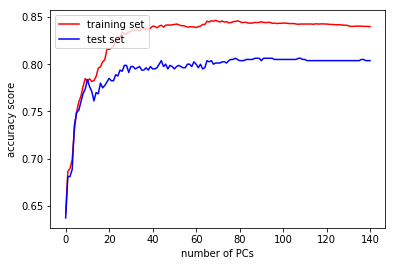

In [52]:
plt.plot(accuracy_trainingSet, 'r', label='training set')
plt.plot(accuracy_testSet, 'b', label='test set')
plt.ylabel('accuracy score')
plt.xlabel('number of PCs')
plt.legend(loc='upper left')
plt.show()

In [53]:
print("Accuracy test set:",accuracy_testSet[-1])
print("Accuracy train set:",accuracy_trainingSet[-1])

Accuracy test set: 0.80375
Accuracy train set: 0.8397003745318352


# Optimizing the Hyperparameters of the SVM

* Kernel: RBF / Linear / Polynomial
* Regularization (parameter C)
* Gamma value
* We could also add weights to the classes (class_weight={1: 10} or so|)

NB:

Regularization:This is how you can control the trade-off between decision boundary and misclassification term. A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.

Gamma: A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting. In other words, you can say a low value of gamma considers only nearby points in calculating the separation line, while the a value of gamma considers all the data points in the calculation of the separation line.

In [ ]:
"""Split data into training and testing sets"""
data_train, data_test, labels_train, labels_test = train_test_split(fKH41_features, fKH41_labels, test_size=0.20, random_state=seed);

In [17]:
"""Changing the kernels --- rbf """

clf = make_pipeline(StandardScaler(), PCA(n_components=opt_PCs), svm.SVC(kernel='rbf', gamma='scale'))
y_score = clf.fit(data_train, labels_train)
y_predict = clf.predict(data_test)
y_predict_train = clf.predict(data_train)
print("Accuracy train set with rbf kernel and gamma = scale:",metrics.accuracy_score(labels_train, y_predict_train))
print("Accuracy test set with rbf kernel and gamma = scale:",metrics.accuracy_score(labels_test, y_predict))


clf = make_pipeline(StandardScaler(), PCA(n_components=opt_PCs), svm.SVC(kernel='rbf', gamma='auto_deprecated'))
y_score = clf.fit(data_train, labels_train)
y_predict = clf.predict(data_test)
y_predict_train = clf.predict(data_train)
print("Accuracy train set with rbf kernel and gamma = auto-deprecated:",metrics.accuracy_score(labels_train, y_predict_train))
print("Accuracy test set with rbf kernel and gamma = auto-deprecated:",metrics.accuracy_score(labels_test, y_predict))

Accuracy train set with rbf kernel and gamma = scale: 0.8480749219562955
Accuracy test set with rbf kernel and gamma = scale: 0.8002081165452654


C:\Users\Constantin\Anaconda3\envs\tftest\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy train set with rbf kernel and gamma = auto-deprecated: 0.8582206035379812
Accuracy test set with rbf kernel and gamma = auto-deprecated: 0.7991675338189386


In [95]:
"""Changing the kernels --- Linear """

clf = make_pipeline(StandardScaler(), PCA(n_components=opt_PCs), svm.SVC(kernel='linear'))
y_score = clf.fit(data_train, labels_train)
y_predict = clf.predict(data_test)
y_predict_train = clf.predict(data_train)
print("Accuracy train set with linear kernel and gamma = scale:",metrics.accuracy_score(labels_train, y_predict_train))
print("Accuracy test set with linear kernel and gamma = scale:",metrics.accuracy_score(labels_test, y_predict))


Accuracy train set with linear kernel and gamma = scale: 0.7991675338189386
Accuracy test set with linear kernel and gamma = scale: 0.7710718002081165


In [97]:
"""Changing the kernels --- Polynomial (degree=6) """

clf = make_pipeline(StandardScaler(), PCA(n_components=opt_PCs), svm.SVC(kernel='poly'))
y_score = clf.fit(data_train, labels_train)
y_predict = clf.predict(data_test)
y_predict_train = clf.predict(data_train)
print("Accuracy train set with polynomial kernel and gamma = scale:",metrics.accuracy_score(labels_train, y_predict_train))
print("Accuracy test set with polynomial kernel and gamma = scale:",metrics.accuracy_score(labels_test, y_predict))


C:\Users\Constantin\Anaconda3\envs\tftest\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy train set with polynomial kernel and gamma = scale: 0.8522372528616025
Accuracy test set with polynomial kernel and gamma = scale: 0.7814776274713839


In [104]:
"""Changing the kernels --- Polynomial (degree=6) """

clf = make_pipeline(StandardScaler(), PCA(n_components=opt_PCs), svm.SVC(kernel='rbf', gamma='scale', C=5))
y_score = clf.fit(data_train, labels_train)
y_predict = clf.predict(data_test)
y_predict_train = clf.predict(data_train)
print("Accuracy train set with polynomial kernel and gamma = scale:",metrics.accuracy_score(labels_train, y_predict_train))
print("Accuracy test set with polynomial kernel and gamma = scale:",metrics.accuracy_score(labels_test, y_predict))

Accuracy train set with polynomial kernel and gamma = scale: 0.8795525494276795
Accuracy test set with polynomial kernel and gamma = scale: 0.7981269510926119


## => We don't see a huge difference between the classifiers so we take the one that overfits the least and keeps the highest accuracy

# Final Model

## 1- Without Probabilistic view

Without Probabilities = True in the SVM Model

The accuracy can be computed but only one point on the ROC curve

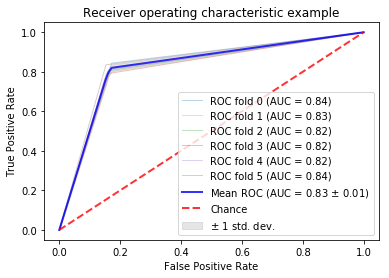

Accuracies training set: [0.84602897 0.84667249 0.84779623 0.84717193 0.84681648 0.84394507]
Accuracies test set: [0.8353088  0.82521848 0.8227216  0.81835206 0.82323548 0.84134916]


In [54]:
""" Final model with rbf """
# Extracted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html


# setup
n_splits = 6
opt_PCs = 80 # Seen to be the best number of PCs from previous analysis

cv = StratifiedKFold(n_splits=n_splits)
clf = make_pipeline(StandardScaler(), PCA(n_components=opt_PCs), svm.SVC(kernel='rbf', gamma='scale'))
accuracies_trainingSet = np.zeros(n_splits)
accuracies_testSet = np.zeros(n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


i = 0
for train, test in cv.split(fKH41_features, fKH41_labels):
    # Model + Accuracies
    data_train, labels_train = fKH41_features[train], fKH41_labels[train]
    data_test, labels_test = fKH41_features[test], fKH41_labels[test]
    y_score = clf.fit(data_train, labels_train)
    y_predict = clf.predict(data_test)
    y_predict_train = clf.predict(data_train)
    accuracies_trainingSet[i] = metrics.accuracy_score(labels_train, y_predict_train)
    accuracies_testSet[i] = metrics.accuracy_score(labels_test, y_predict)
    
    # ROC curves and area the curve
    fpr, tpr, thresholds = roc_curve(labels_test, y_predict)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')       
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

    
print("Accuracies training set:",accuracies_trainingSet)
print("Accuracies test set:",accuracies_testSet)

## 2- Creating a precise ROC curve using several thresholds with the Probabilistic view

With Probabilities = True in the SVM Model

No accuracy can be computed (apparently)

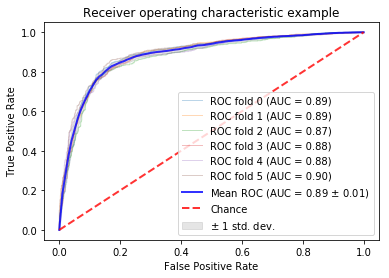

In [55]:
""" Final model with rbf """
# Extracted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html


# setup
n_splits = 6
opt_PCs = 80 # Seen to be the best number of PCs from previous analysis
cv = StratifiedKFold(n_splits=n_splits)
# clf = make_pipeline(StandardScaler(), PCA(n_components=opt_PCs), svm.SVC(kernel='rbf', gamma='scale'))
clf = make_pipeline(StandardScaler(), PCA(n_components=opt_PCs), svm.SVC(kernel='rbf', gamma='scale', probability=True))
# accuracies_trainingSet = np.zeros(n_splits)
# accuracies_testSet = np.zeros(n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


i = 0
for train, test in cv.split(fKH41_features, fKH41_labels):
    # Model + Accuracies
    data_train, labels_train = fKH41_features[train], fKH41_labels[train]
    data_test, labels_test = fKH41_features[test], fKH41_labels[test]
    y_score = clf.fit(data_train, labels_train)
#     y_predict = clf.predict(data_test)
    y_predict = clf.predict_proba(data_test)
    y_predict_train = clf.predict(data_train)
#     accuracies_trainingSet[i] = metrics.accuracy_score(labels_train, y_predict_train)
#     accuracies_testSet[i] = metrics.accuracy_score(labels_test, y_predict)
    
    # ROC curves and area the curve
    fpr, tpr, thresholds = roc_curve(labels_test, y_predict[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')       
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

    
# print("Accuracies training set:",accuracies_trainingSet)
# print("Accuracies test set:",accuracies_testSet)

# Just a small test of ROC curves

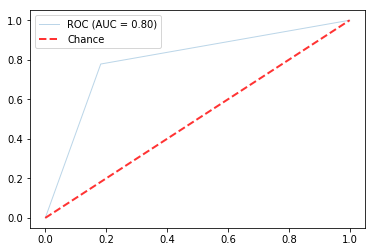

In [18]:
"""Run a ROC and display AUC"""
from sklearn.metrics import roc_curve, auc
from scipy import interp

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


# probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])


# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(labels_test, y_predict)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3,
         label='ROC (AUC = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.legend(loc='upper left')

In [26]:
"""Some tests"""

print(thresholds)

confusion_matrix(labels_test, y_predict) 

print(np.unique(labels_train))

[2 1 0]
[0 1]
